In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast 

In [7]:
df = pd.read_csv("cleaned_data.csv")
df['job_skills'] = df['job_skills'].apply(
    lambda skills_list : ast.literal_eval(skills_list) if pd.notna(skills_list) else skills_list
)

In [31]:
df_DA_US = df[(df.job_title_short == "Data Analyst") & (df.job_country == "United States")].copy()
df_DA_US = df_DA_US.dropna(subset="salary_year_avg")
df_DA_exploded = df_DA_US.explode("job_skills")

df_DA_skills = df_DA_exploded.groupby("job_skills")["salary_year_avg"].agg(["count", "median"]).sort_values(ascending=False, by="count")
df_DA_skills = df_DA_skills.rename(
   columns={
        "count" : "skill_count", 
        "median" : "median_salary"
    }
)

DA_US_job_count = len(df_DA_US)
df_DA_skills["skill_percent"] = df_DA_skills.skill_count / DA_US_job_count * 100

skill_percent = 5
df_DA_skill_high_demand = df_DA_skills[df_DA_skills.skill_percent > skill_percent]


In [45]:
df_technology = df["job_type_skills"].copy()
df_technology.drop_duplicates(inplace=True)
df_technology.dropna(inplace=True)

technology_dict = {}
for row in df_technology : 
    row_dict = ast.literal_eval(row)
    for key, value in row_dict.items():
        if key in technology_dict : 
            technology_dict[key] += value
        else : 
            technology_dict[key] = value

for key, value in technology_dict.items():
    technology_dict[key] = list(set(value))

In [58]:
df_technology = pd.DataFrame(list(technology_dict.items()), columns=["technology", "skills"])
df_technology = df_technology.explode("skills")

df_plot = df_DA_skill_high_demand.merge(df_technology, left_on="job_skills", right_on="skills")



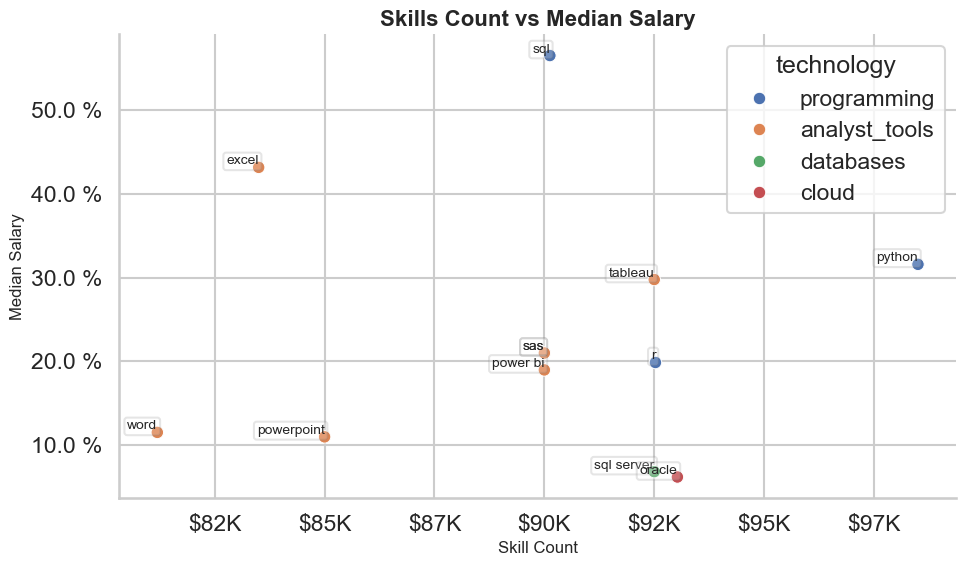

In [57]:
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df_plot,
    y="skill_percent",  
    x="median_salary",
    hue="technology"
)

for i, text in enumerate(df_plot.index):
    plt.text(
        y=df_plot["skill_percent"].iloc[i],  
        x=df_plot["median_salary"].iloc[i],
        s=df_plot["skills"].iloc[i],  
        fontsize=10,
        ha='right',
        va='bottom',
        bbox=dict(boxstyle="round,pad=0.2", edgecolor="gray", facecolor="white", alpha=0.2)  
    )


plt.title("Skills Count vs Median Salary", fontsize=16, fontweight='bold')
plt.xlabel("Skill Count", fontsize=12)
plt.ylabel("Median Salary", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, __ : f"${int(y/1000)}K" ))
ax.yaxis.set_major_formatter(lambda x , _ : f'{x} %')


sns.despine()

plt.tight_layout()
plt.show()
